In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten, Concatenate
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import utils
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import math

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
header_list = ["date", "open", "high", "low", "close", "volume"]
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GBP_USD.csv")

Including the technical analysis to this dataset

In [31]:
!python --version    # more help to install taLib  https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib as ta

Python 3.7.13
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4029    0  4029    0     0  17366      0 --:--:-- --:--:-- --:--:-- 17366
100  503k  100  503k    0     0   899k      0 --:--:-- --:--:-- --:--:--  899k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4069    0  4069    0     0  22480      0 --:--:-- --:--:-- --:--:-- 22605
100  406k  100  406k    0     0   740k      0 --:--:-- --:--:-- --:--:--  740k


In [32]:
import talib as ta

def addIndicators(df):

    df['RSI5'] = ta.RSI(df['close'], timeperiod=5)
    df['RSI10'] = ta.RSI(df['close'], timeperiod=10)
    df['RSI20'] = ta.RSI(df['close'], timeperiod=20)

    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], \
                                                                 fastperiod=12, slowperiod=26, signalperiod=9)

    df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], \
                                            df['close'], fastk_period=5, slowk_period=3, slowk_matype=0,
                                            slowd_period=3, slowd_matype=0)
    df['fastk'], df['fastd'] = ta.STOCHF(df['high'], df['low'], \
                                             df['close'], fastk_period=5, fastd_period=3, fastd_matype=0)

    df['WR5'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=5)
    df['WR10'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=10)
    df['WR20'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=20)

    df['ROC5'] = ta.ROC(df['close'], timeperiod=5)
    df['ROC10'] = ta.ROC(df['close'], timeperiod=10)
    df['ROC20'] = ta.ROC(df['close'], timeperiod=20)


    df['CCI5'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=5)
    df['CCI10'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=10)
    df['CCI20'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=20)

    df['ATR5'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=5)
    df['ATR10'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=10)
    df['ATR20'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=20)

    df['NATR5'] = ta.NATR(df['high'], df['low'], df['close'], timeperiod=5)
    df['NATR10'] = ta.NATR(df['high'], df['low'], df['close'], timeperiod=10)
    df['NATR20'] = ta.NATR(df['high'], df['low'], df['close'], timeperiod=20)

    df['TRANGE'] = ta.TRANGE(df['high'], df['low'], df['close'])
    return df
df = addIndicators(df)

In [9]:
df.describe()

,index,open,high,low,close,volume,RSI5,RSI10,RSI20,macd,...,CCI5,CCI10,CCI20,ATR5,ATR10,ATR20,NATR5,NATR10,NATR20,TRANGE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99995.000000,99990.000000,99980.000000,99967.000000,...,99996.000000,99991.000000,99981.000000,99995.000000,99990.000000,99980.000000,99995.000000,99990.000000,99980.000000,99999.000000
mean,50000.500000,1.315367,1.315866,1.314863,1.315367,488.114700,50.015566,49.971070,49.922449,-0.000013,...,0.222304,-0.104221,-0.166787,0.001009,0.001009,0.001009,0.076588,0.076592,0.076596,0.001009
std,28867.657797,0.065221,0.065264,0.065179,0.065218,665.343805,18.677930,13.457710,9.968725,0.000969,...,93.625614,105.645501,115.215069,0.000701,0.000623,0.000536,0.052360,0.046442,0.039781,0.000999
min,1.000000,1.196310,1.197620,1.164960,1.196280,1.000000,0.966524,2.778080,6.507691,-0.036560,...,-166.666667,-333.333333,-666.666667,0.000127,0.000186,0.000239,0.009512,0.013898,0.018961,0.000000
25%,25000.750000,1.271848,1.272280,1.271408,1.271860,150.000000,36.630998,41.060099,43.467822,-0.000400,...,-83.097328,-83.333333,-83.449667,0.000574,0.000629,0.000705,0.043664,0.047805,0.053735,0.000490
50%,50000.500000,1.303640,1.304030,1.303240,1.303640,317.000000,50.069119,50.003342,49.829200,-0.000006,...,0.951024,0.194704,0.134320,0.000881,0.000904,0.000922,0.067250,0.069079,0.070348,0.000800
75%,75000.250000,1.340120,1.340780,1.339560,1.340113,614.000000,63.403849,58.946837,56.455171,0.000396,...,83.546280,83.072943,82.910135,0.001277,0.001244,0.001191,0.096941,0.094554,0.090601,0.001260
max,100000.000000,1.500760,1.501900,1.499180,1.500740,33473.000000,99.410204,96.173504,88.787190,0.009308,...,166.666667,333.333333,639.271049,0.029304,0.023159,0.017344,2.157610,1.705181,1.295552,0.096500


In [5]:
df.dtypes

open      object
high      object
low       object
close     object
volume    object
dtype: object

In [13]:
df.shape

(100000, 32)

Now, we need to remove the NAN values from our dataset 

In [33]:
df.bfill(inplace=True)

In [34]:
df.isnull().sum() #checking NAN values 

index         0
date          0
open          0
high          0
low           0
close         0
volume        0
RSI5          0
RSI10         0
RSI20         0
macd          0
macdsignal    0
macdhist      0
slowk         0
slowd         0
fastk         0
fastd         0
WR5           0
WR10          0
WR20          0
ROC5          0
ROC10         0
ROC20         0
CCI5          0
CCI10         0
CCI20         0
ATR5          0
ATR10         0
ATR20         0
NATR5         0
NATR10        0
NATR20        0
TRANGE        0
dtype: int64

separating the dataset by selecting the important technical analysis 

In [100]:
df1 = []
df1 = df.loc[:, ["date","close","macd","ROC5"]]

In [13]:
df1.dtypes

date      object
close    float64
macd     float64
ROC5     float64
dtype: object

In [18]:
df1.shape

(100000, 4)

In [101]:
df1['date'] = pd.to_datetime(df1['date'])
df1.head()

,date,close,macd,ROC5
0,2015-12-18 16:30:00+00:00,1.49030,0.000221,-0.042944
1,2015-12-18 16:45:00+00:00,1.49108,0.000221,-0.042944
2,2015-12-18 17:00:00+00:00,1.49041,0.000221,-0.042944
3,2015-12-18 17:15:00+00:00,1.48994,0.000221,-0.042944
4,2015-12-18 17:30:00+00:00,1.49010,0.000221,-0.042944


In [102]:
df1['date'] = df1.index

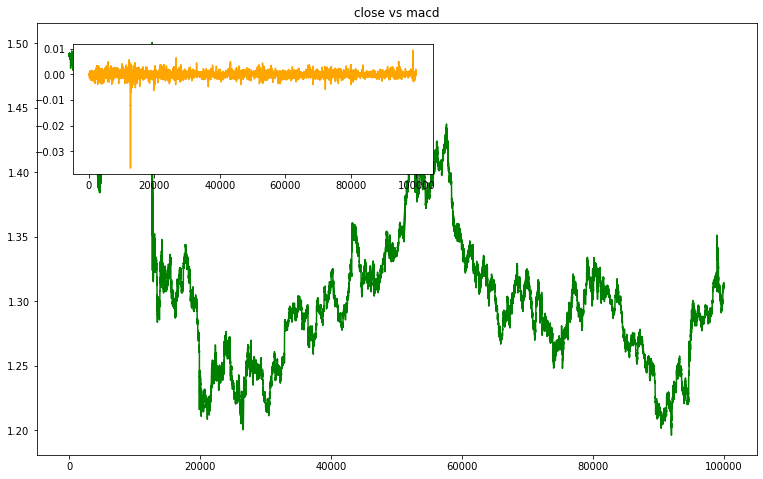

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_axes([0,0,1,1])
ax2 = fig.add_axes([0.05,0.65,0.5,0.3])

ax1.set_title('close vs macd')
ax1.plot(df1['date'],df1['close'],color ='green',label = 'slowd')
ax2.plot(df1['date'],df1['macd'],color ='orange',label = 'macd')
plt.show()

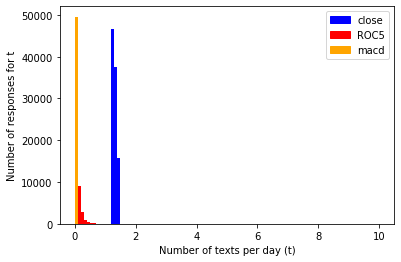

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
start,end,n_bins = 0,10,100
_,_,_ = plt.hist(df1['close'], bins=n_bins, range=(start,end), color='blue')
_,_,_ = plt.hist(df1['ROC5'], bins=n_bins, range=(start,end), color='red')
_,_,_ = plt.hist(df1['macd'], bins=n_bins, range=(start,end), color='orange')
_ = plt.legend(handles=[mpatches.Patch(color='blue', label='close'),
                    mpatches.Patch(color='red', label='ROC5'),
                    mpatches.Patch(color='orange', label='macd')])
_ = plt.xlabel('Number of texts per day (t)')
_ = plt.ylabel('Number of responses for t')

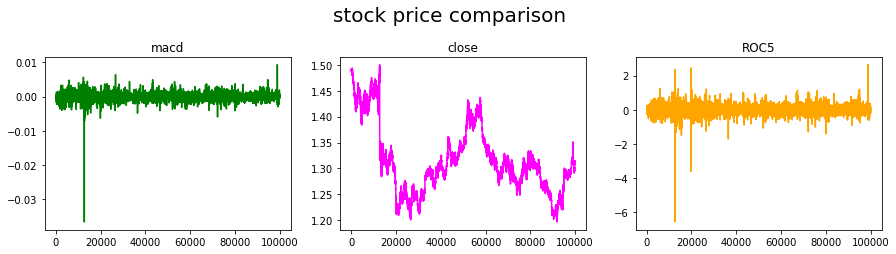

In [50]:
fig = plt.figure(figsize = (15,7))

fig.suptitle('stock price comparison',fontsize = 20)

ax1 = fig.add_subplot(231)
ax1.set_title('macd')

ax1.plot(df1['date'],df1['macd'],color ='green')

ax2 = fig.add_subplot(232)
ax2.set_title('close')

ax2.plot(df1['date'],df1['close'],color ='magenta')

ax3 = fig.add_subplot(233)
ax3.set_title('ROC5')

ax3.plot(df1['date'],df1['ROC5'],color ='orange')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


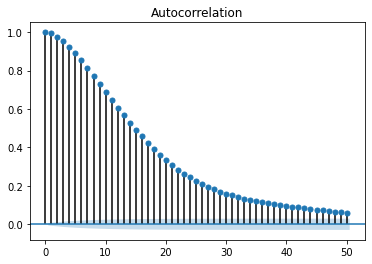

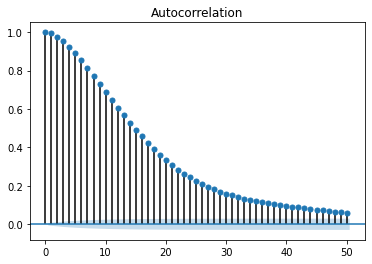

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1.macd)

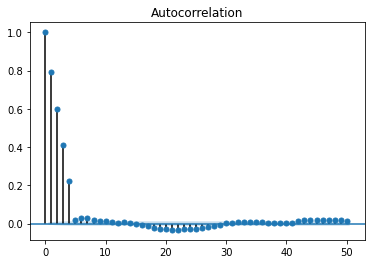

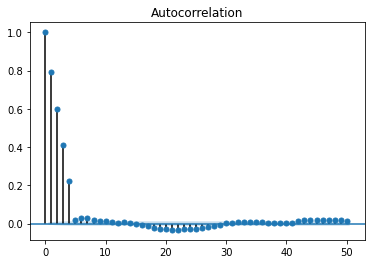

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1.ROC5)

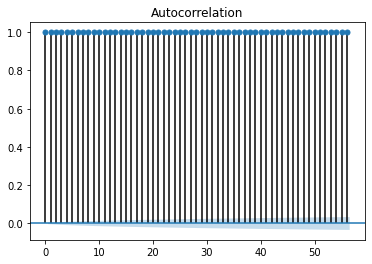

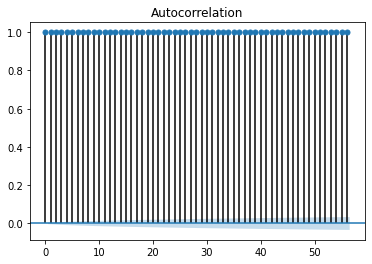

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1.close)

In [113]:
x = df1['close']

In [114]:
returns = x.pct_change(1).dropna() #using the one-day lag

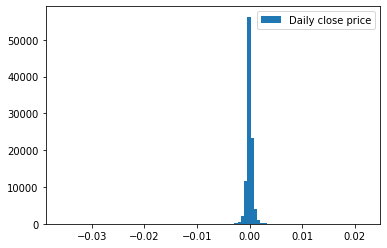

In [115]:
plt.hist(returns,bins="rice",label="Daily close price")
plt.legend()
plt.show()

In [116]:
np.mean(returns) #its a bad sign 

-1.0743255683099542e-06

In [117]:
np.std(returns)#magnitude higher than mean value. SD is the measure of risk 

0.0006421196659628792

In [118]:
np.quantile(returns,0.5) # The theoretical 0% quantile of the normal distribution is indeed -Inf. For the exponential distribution it would be 0.

0.0

In [119]:
np.quantile(returns,0.5) # The theoretical 0% quantile of the normal distribution is indeed -Inf. For the exponential distribution it would be 0.

0.0

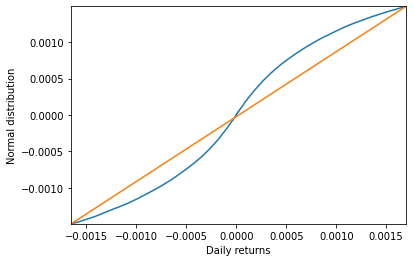

In [122]:
from scipy.stats import norm
t = np.linspace(0.01,0.99,1000)
q1 = np.quantile(returns,t)
q2 = norm.ppf(t,loc=np.mean(returns),scale=np.std(returns))
plt.plot(q1,q2)
plt.plot([min(q1),max(q1)],[min(q2),max(q2)])
plt.xlim((min(q1),max(q1)))
plt.ylim((min(q2),max(q2)))
plt.xlabel("Daily returns")
plt.ylabel("Normal distribution")
plt.show()

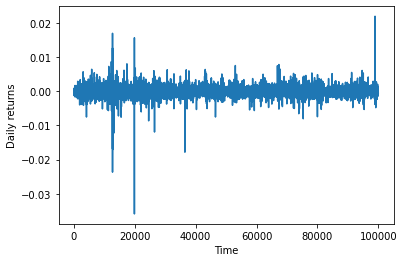

In [123]:
plt.plot(returns)
plt.xlabel("Time")
plt.ylabel("Daily returns")
plt.show()

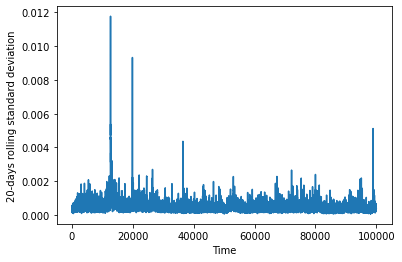

In [124]:
plt.plot(returns.rolling(20).std())
plt.xlabel("Time")
plt.ylabel("20-days rolling standard deviation")
plt.show()

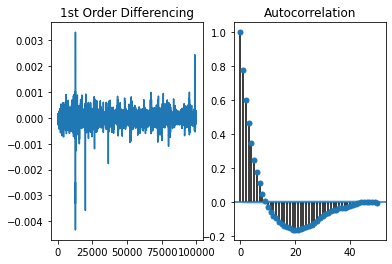

In [53]:
f = plt.figure()
ax1 = f.add_subplot (121) 
ax1.set_title('1st Order Differencing')
ax1.plot(df1.macd.diff())

ax2 = f.add_subplot (122)
plot_acf(df1.macd.diff().dropna(), ax=ax2)
plt.show()

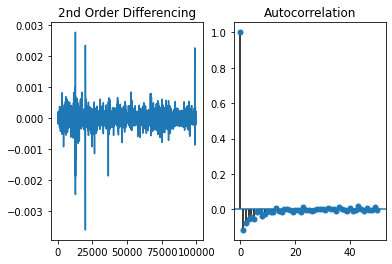

In [54]:
f = plt.figure()
ax1 = f.add_subplot (121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df1.macd.diff().diff())

ax2 = f.add_subplot (122)
plot_acf(df1.macd.diff().diff().dropna (), ax=ax2)
plt.show()

Stack plot and stem plot 

```
# This is formatted as code
```



In [ ]:
x = df1['datetime']

y = np.vstack([df1['close'],df1['macd'],df1['ROC5']])

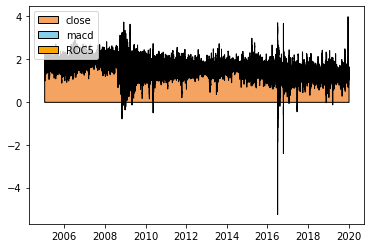

In [ ]:
labels = ['close','macd','ROC5']

colors = ['sandybrown','skyblue','orange']

plt.stackplot(x,y,labels=labels,colors=colors,edgecolor='black')

plt.legend(loc=2)

plt.show()

Scatter plot 

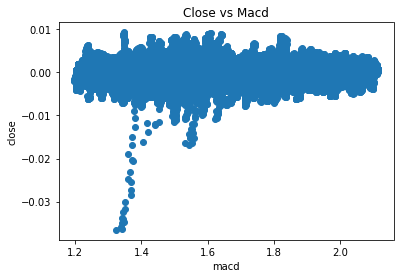

In [ ]:
plt.scatter(df1['close'],df1['macd'])
plt.title('Close vs Macd')
plt.xlabel('macd')
plt.ylabel('close')
plt.show()

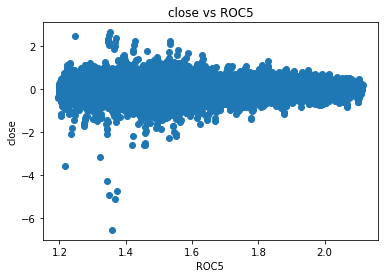

In [ ]:
plt.scatter(df1['close'],df1['ROC5'])
plt.title('close vs ROC5')
plt.xlabel('ROC5')
plt.ylabel('close')
plt.show()

In [55]:
df1['close'].corr(df1['macd'])

0.023418303798900992

In [56]:
df1['close'].corr(df1['ROC5'])

0.008614666541593336

In [28]:
df1 = df1.set_index('date')

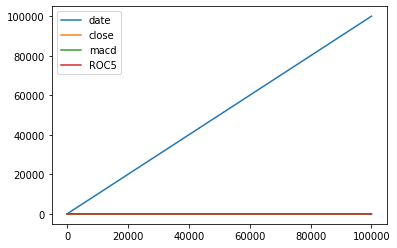

In [57]:
from matplotlib import pyplot
df1.plot()

In [ ]:
df1.values

array([[ 1.91930000e+00, -4.07380990e-03,  2.60511645e-02],
       [ 1.91940000e+00, -4.07380990e-03,  2.60511645e-02],
       [ 1.91970000e+00, -4.07380990e-03,  2.60511645e-02],
       ...,
       [ 1.31168000e+00, -1.86162116e-04,  5.26319804e-02],
       [ 1.31184000e+00, -1.46284104e-04,  3.81289368e-02],
       [ 1.31115000e+00, -1.68416327e-04, -4.80263459e-02]])

In [58]:
df1.var()

date     8.333417e+08
close    4.253422e-03
macd     9.391252e-07
ROC5     1.979505e-02
dtype: float64

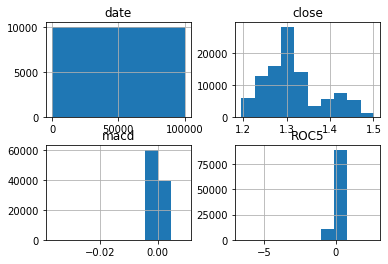

In [59]:
from matplotlib import pyplot

df1.hist()
pyplot.show()

In [60]:
df1.mean()

date     49999.500000
close        1.315367
macd        -0.000012
ROC5        -0.000541
dtype: float64

In [61]:
np.corrcoef(
    df1['close'],
    df1['macd'],
)

array([[1.       , 0.0234183],
       [0.0234183, 1.       ]])

In [62]:
np.corrcoef(
    df1['ROC5'],
    df1['close'],
)

array([[1.        , 0.00861467],
       [0.00861467, 1.        ]])

Time series decomposition - macd


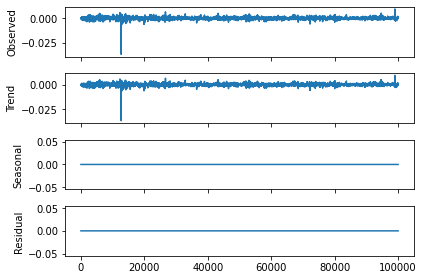

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
res_ma = seasonal_decompose(df1['macd'], freq=1, model='additive') # one month seasonality 

print("Time series decomposition - macd")
res_ma.plot()
plt.show()

Time series decomposition - ROC5


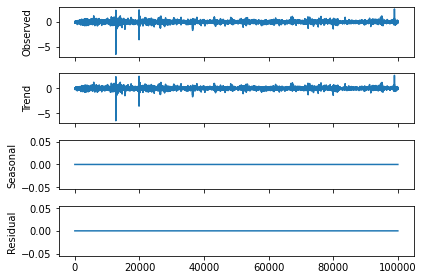

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
res_roc = seasonal_decompose(df1['ROC5'], freq=1, model='additive')

print("Time series decomposition - ROC5")
res_roc.plot()
plt.show()

AUGMENTED DICKY- FULLER TEST 

In [32]:
from statsmodels.tsa.stattools import adfuller

X = df1['macd'].values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -28.513231
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


From the above ADF test, we would have to reject the null hypothesis that the time series is non-stationary and does have time-dependent **structure**

*Now*, we are going to add log transform the dataset again to make the distribution of values more linear and better meet the expectations of this statistical test

In [34]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
X = df['close'].values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.849975
p-value: 0.051482
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


TESTING DISTRIBUTIONS 


Alpha  distributed data is done below 

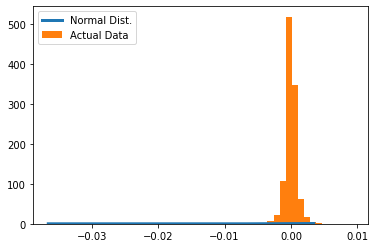

In [38]:
# Plot a histogram of the observed data
#  Included is expected distribution, if the data is normally distributed, with the same mean and std of the data.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import normaltest


xs = np.arange(df['macd'].min(), df['macd'].max(), 0.01)
fit = stats.norm.pdf(xs, np.mean(df['macd']), np.std(df['macd']))
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(df['macd'], 50, density=True, label='Actual Data');
plt.legend();

In [39]:
import scipy.stats as stats
def check_p_val(p_val, alpha):

    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')


stat, p_val = stats.normaltest(df['close'])
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


In [27]:
import scipy.stats as stats
def check_p_val(p_val, alpha):

    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')


stat, p_val = stats.normaltest(df1['macd'])
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


Beta distributed curve is done below 

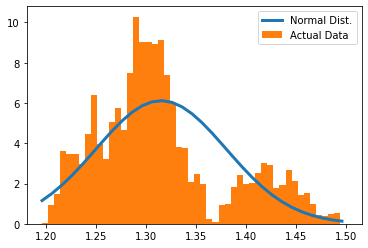

In [40]:
# Plot the data with with expected distribution, under the hypothesis that it is normally distributed. 
#  The blue line is the expected data density, with the same mean and standard deviation, if the data are normal. 
xs = np.arange(df['close'].min(), df['close'].max(), 0.01)
fit = stats.norm.pdf(xs, np.mean(df['close']), np.std(df['close']))
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(df['close'], 50, density=True, label='Actual Data');
plt.legend();

In [41]:
# Run normal test on the data
stat, p_val = normaltest(df['close'])

In [ ]:
# Check the p-value of the normaltest
print('\nNormaltest p-value is: {:1.2e} \n'.format(p_val))

# With alpha value of 0.05, how should we proceed
check_p_val(p_val, alpha=0.05)

In [42]:
from scipy.stats import kstest
# Let's continue using our data from above, from the beta distribution. 
#   We can confirm kstest considers it not normally distributed  
stat, p_val = kstest(df['close'], 'norm')
print('Statistic: \t{:1.2f} \nP-Value: \t{:1.2e}\n'.format(stat, p_val))
check_p_val(p_val, alpha=0.05)

Statistic: 	0.89 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis.


In [43]:
# Now compare the data to the beta distribution.
#   Note that in this case, we have to specify some parameters for the beta 
#   distribution we are testing against, so we will use the simulation parameters
stat, p_val = kstest(df['close'], 'beta', [7, 10])
print('Statistic: \t{:1.2f} \nP-Value: \t{:1.2e}\n'.format(stat, p_val))
check_p_val(p_val, alpha=0.05)

Statistic: 	1.00 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis.


In [44]:
#manually calculate correlation coefficents - normalise by stdev.
df1 = df['close'].dropna()
m = df['close'].mean(axis=0)
s = df['close'].std(ddof=1, axis=0)
 
# normalised time-series as an input for PCA
combo_pca = (df1 - m)/s
 
c = np.cov(combo_pca.values.T)     # covariance matrix   
co = np.corrcoef(combo_pca.values.T) #correlation matrix

In [48]:
df1

3202    1.49030
3203    1.49108
3204    1.49041
3205    1.48994
3206    1.49010
         ...   
481     1.31191
482     1.31209
483     1.31168
484     1.31184
485     1.31115
Name: close, Length: 100000, dtype: float64

In [16]:
df1[df1.index.duplicated()]

,date,close,macd,ROC5


In [18]:
import pandas
import numpy as np


corr1 = df1['close'].corr(df1['macd'],method='pearson', min_periods=1)
print(corr1)

0.023418303798900992


In [19]:
corrM = df1.corr()
corrM

,close,macd,ROC5
close,1.000000,0.023418,0.008615
macd,0.023418,1.000000,0.344304
ROC5,0.008615,0.344304,1.000000


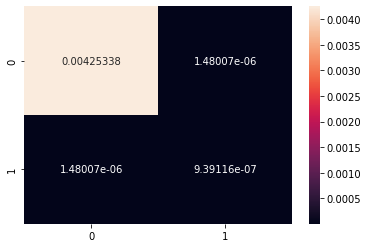

In [26]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
covMatrix = np.cov(df1['close'],df1['macd'],bias=True)
sn.heatmap(covMatrix, annot=True, fmt='g')
plt.show()


Splitting the cells 

In [ ]:
df1

,close,macd,ROC5
date,,,
2015-12-18 16:30:00+00:00,1.49030,0.000221,-0.042944
2015-12-18 16:45:00+00:00,1.49108,0.000221,-0.042944
2015-12-18 17:00:00+00:00,1.49041,0.000221,-0.042944
2015-12-18 17:15:00+00:00,1.48994,0.000221,-0.042944
2015-12-18 17:30:00+00:00,1.49010,0.000221,-0.042944
...,...,...,...
2019-12-30 22:30:00+00:00,1.31191,-0.000297,0.090790
2019-12-30 22:45:00+00:00,1.31209,-0.000218,0.080089
2019-12-30 23:00:00+00:00,1.31168,-0.000186,0.052632


Linear Regression

In [103]:
#x = np.array(df1.drop(['close'],1).values)
x = np.array(df1.drop(['close', 'date'], axis = 1).values)
y = df1['close'].values

In [ ]:
#x = df1.drop(index=('close'),axis=1).values
#x = df1.drop(['close'],axis=1).values
#y = df['close'].values

In [ ]:
df1 = df1.set_index('date')

Splitting the data

In [104]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Train the model on the model 

Predict the test results 

In [ ]:
y_pred = ml.predict(x_test)
print(y_pred)

[1.31489786 1.31554449 1.31514419 ... 1.31576542 1.31405273 1.31716041]


Evaluate model (R2 - Score ) 

In [ ]:
from sklearn.metrics import r2_score 
r2_score(y_test,y_pred)

9.658529848211028e-05

Linear Regression

In [105]:
 import numpy as np
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [106]:
 r_sq = model.score(x_test, y_test)

In [84]:
r_sq

9.658529848211028e-05

In [82]:
new_model = LinearRegression().fit(x_train, y_train)

Plotting 

Text(0.5, 1.0, 'Actual vs predicted')

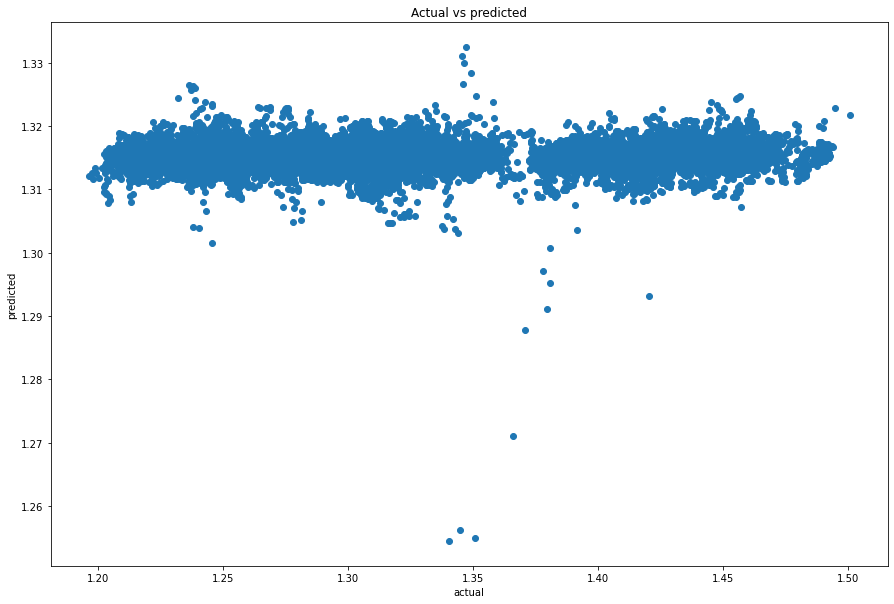

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Actual vs predicted')

Predicted values

In [ ]:
pred_y_df = pd.DataFrame({'Actual value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})

In [ ]:
pred_y_df

,Actual value,Predicted Value,Difference
0,1.44608,1.314898,0.131182
1,1.33154,1.315544,0.015996
2,1.38400,1.315144,0.068856
3,1.21792,1.315734,-0.097814
4,1.43282,1.315187,0.117633
...,...,...,...
29995,1.27166,1.315115,-0.043455
29996,1.33825,1.315181,0.023069
29997,1.29694,1.315765,-0.018825
29998,1.23876,1.314053,-0.075293


Decision - Tree (Regressor) 

In [107]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=3)
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=3)

In [108]:
cross_val_score(dt, x_test, y_test, cv=10)

array([ 6.73466145e-03,  1.06598757e-02, -4.82236384e-05,  3.98053238e-03,
        7.09437614e-03,  4.78034656e-03,  9.56424809e-03,  9.10882808e-03,
        3.43532451e-03,  3.68866107e-03])

In [109]:
cv_pd = dt.score(x_train,y_train)

Predict 

In [ ]:
y_pred = dt.predict(x_test)
print(y_pred)

[1.30821645 1.30821645 1.30821645 ... 1.31884382 1.31402295 1.32798064]


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
mse_dt = MSE(y_test,y_pred)

In [ ]:
rmse_dt = mse_dt**(1/2)

In [ ]:
rmse_dt

0.06515691333542693

In [ ]:
from sklearn.metrics import r2_score 
r2_score(y_test,y_pred)

0.005450385670306868

Plotting 

Text(0.5, 1.0, 'Actual vs predicted')

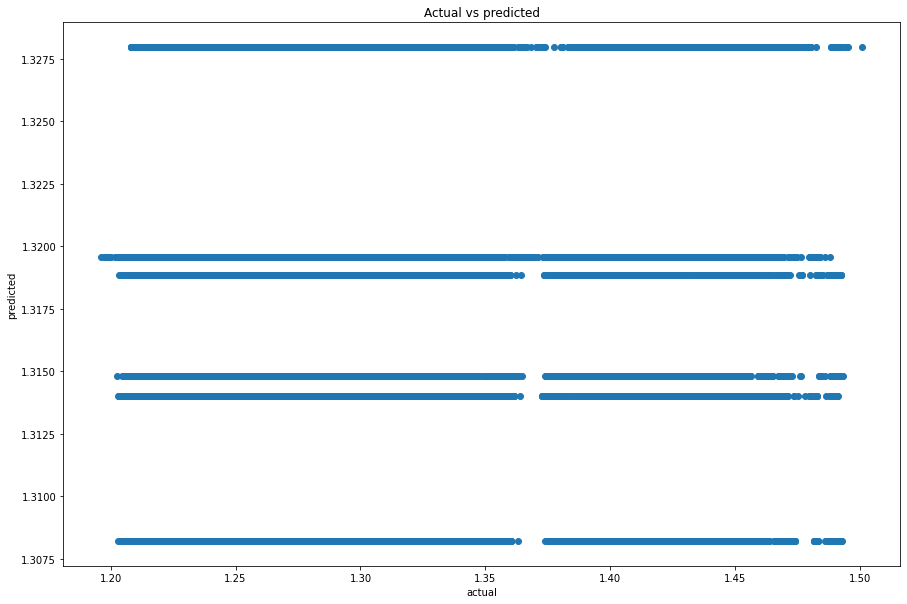

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Actual vs predicted')

Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [110]:
x_train, y_train = make_regression(n_features=2, n_informative=2,random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [111]:
cx_pdf = regr.score(x_train, y_train, sample_weight=None)

Random Forest Classifier

Labelling

In [89]:
import math
forecast_out = int(math.ceil(0.05 * len(df1))) # forcasting out 5% of the entire dataset
print(forecast_out)
df1['label'] = df1['close'].shift(-forecast_out)
df1['label1'] = df1['macd'].shift(-forecast_out)

5000


In [91]:
df2 = df1[['close','macd','label']]

In [92]:
df2['label'].fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [94]:
df2

,close,macd,label
0,1.49030,0.000221,1.41688
1,1.49108,0.000221,1.41614
2,1.49041,0.000221,1.41640
3,1.48994,0.000221,1.41668
4,1.49010,0.000221,1.41648
...,...,...,...
99995,1.31191,-0.000297,0.00000
99996,1.31209,-0.000218,0.00000
99997,1.31168,-0.000186,0.00000
99998,1.31184,-0.000146,0.00000


In [95]:
x = np.array(df2.drop(['label'], axis = 1).values)
y = df2['label'].values

In [96]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [98]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=2, random_state=0) #used regressor as classifier is not good in working with floats 
model = clf.fit(x_train, y_train)
rdmf_sq = model.score(x_test,y_test)

In [99]:
rdmf_sq

0.11287758475504672

Final Conclusion

In [112]:
names = ['Linear Regressor', 'Decision Tree - Regressor', 'Random Forest Regressor', 'Random Forest Classifier']
columns = ['model', 'accuracy']
scores = [r_sq, cv_pd,cx_pdf, rdmf_sq]
alg_vs_score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
alg_vs_score

,model,accuracy
0,Linear Regressor,0.000097
1,Decision Tree - Regressor,0.008508
2,Random Forest Regressor,0.905842
3,Random Forest Classifier,0.112878
